In [355]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
    

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Lesson 6: Random Forests

In this mini-project we'll be building a random forest classifier trained on the *Titanic* dataset and attempting to tune it.

In [356]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score
np.random.seed(99)

To get a baseline, we can start by training a single decision tree. Random forests contain many decision trees, trained on differents subsets of the dataset (often called estimators), and average their results. This theory behind this technique is that sampling from many uncorrelated estimators should produce a balaced error distribution across the many estimators. Taking the mean of the errors from each estimator should results in a mean error that is close to 0! (This assumes a balanced distribution of positive and negative errors). Thus adding more estimators, as long as they remain uncorrelated, should result in a smaller error.

First we can load the dataset. Decision trees are a great model for training on categorical data, because they don't require data to be normalized as in a neurel net, instead they can simply split numerical data at a certain value. When we trained a linear model, we needed to use the log function to help alleviate the long tail in the 'Fare' column as well as normalize every column to be between 0 and 1. For decision trees, we simply need to make sure that our data is numeric:

In [357]:
df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

def preprocess_df(data, is_test=False):
    modes = data.mode().iloc[0]
    data.fillna(modes, inplace=True)
    data['Sex'] = pd.Categorical(data.Sex).codes
    data['Embarked'] = pd.Categorical(data.Embarked).codes
    inputs = data[['Fare', 'SibSp', 'Parch', 'Age', 'Sex', 'Pclass', 'Embarked']]
    actuals = None
    if not is_test:
        actuals = df['Survived']
    return inputs, actuals

train_inputs, train_actuals = preprocess_df(df)
test_inputs, _ = preprocess_df(test_df, is_test=True)
train_inputs.head()

,Fare,SibSp,Parch,Age,Sex,Pclass,Embarked
0,7.2500,1,0,22.0,1,3,2
1,71.2833,1,0,38.0,0,1,0
2,7.9250,0,0,26.0,0,3,2
3,53.1000,1,0,35.0,0,1,2
4,8.0500,0,0,35.0,1,3,2


Next we can split our training data into training and validation sets.

In [358]:
trn_X, val_X, trn_y, val_y = train_test_split(train_inputs, train_actuals, test_size=0.2, random_state=99)
print(trn_X.shape[0], val_X.shape[0])

712 179


It's worth noting that our dataset is very small, so a slightly lower/higher accuracy score may not be a reliable indicator while tuning models.

Next, we can train a Decision Tree Classifier. We can constrain the size of the tree by setting max_leaf_nodes to a value.

In [359]:
dt = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_X, trn_y)

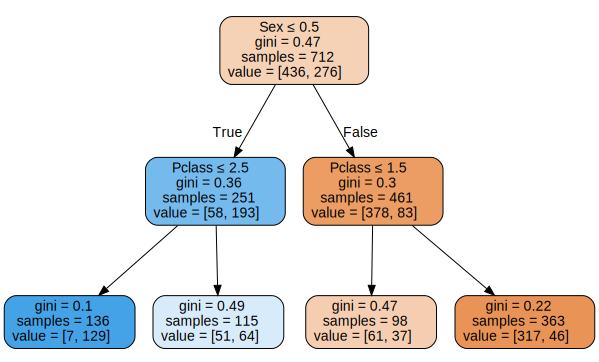

In [360]:
import graphviz
import re

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))
draw_tree(dt, trn_X, size=10)

We can view how the decision tree fits the data by exporting the tree to an image via GraphViz. We can see that the tree first splits on *Sex*, and for good reason, as 193/251 females (sex == 0) survived, making it a great predictor. The decision tree splits females next by class, with the upper 2 classes boasting a survival rate of 129/136, while the lower class was split down the middle 64/115. On the male side, the decision tree found that the next best way to predict survival was also pclass, with first class male passengers faring much better (37/98) than second and third class males (46/363).

Next, we can measure the accuracy of this model on the validation set.

In [361]:
mean_absolute_error(val_y, dt.predict(val_X))

0.2737430167597765

This error rate is pretty good result for a single decision tree, let's submit it to the competion and see how we do.

In [362]:
def make_submission(preds, test_df, suff):
    test_df['Survived'] = preds
    sub_df = test_df[['PassengerId', 'Survived']]
    fname = f'submission.csv'
    sub_df.to_csv(fname, index=False)
    
# make_submission(dt.predict(test_inputs.values), test_df, 'dt_1')

We acheived a submission score of 77.0% accuracy, which is not bad for our first attempt.

Next, we can try emsembling many decision trees in order to build a random forest classifier. Fortunately, sklearn already has the *RandomForestClassifier* we can use that performs the ensembling. As we spoke about before, introducing many random correlated trees by sampling random subsets of rows from the dataset should improve our accuracy by reducing mean error across the collection of trees as we add more and more. Given that the dataset is so tiny however, we may not see that much in the way of performance gains (foreshadowing). 

We will start by utilizing 5 trees, with a min_samples per leaf set to 20. This should give a slightly more expanded decision tree, as the min leaf size we saw on our original tree was ~100.

In [363]:
rf = RandomForestClassifier(5, min_samples_leaf = 20, oob_score=True)
rf.fit(trn_X.values, trn_y.values)
mean_absolute_error(val_y.values, rf.predict(val_X.values))

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


0.16759776536312848

Our error has gone down slightly now that we are using more than one decision tree, we can try submitting again to see if we fare better.

In [364]:
make_submission(rf.predict(test_inputs.values), test_df, 'rf_1')

This submission received an accuracy score of 75.1%, which is actually lower than before! I'll echo again that it's important not to read too far into this accuracy score, as our dataset is so tiny. If we were training and validation on a much larger dataset, then we could trust deviations in the accuracy of our model with more confidence.

That being said, there are still techniques we can use to try to improve our model.

For starters, we know that in theory using more estimators in our random forest should drive the error rate down. Let's hold *min_samples_leaf* constant while increasing the number of estimators to 100.

In [365]:
rf = RandomForestClassifier(100, min_samples_leaf = 20, oob_score=True)
rf.fit(trn_X.values, trn_y.values)
mean_absolute_error(val_y.values, rf.predict(val_X.values))

0.22905027932960895

Our accuracy has actually decreased, but as I've said before and as we've discussed in class, with a dataset this small YMMV. Let's plot the accuracy across random forests of size 1 to 100:

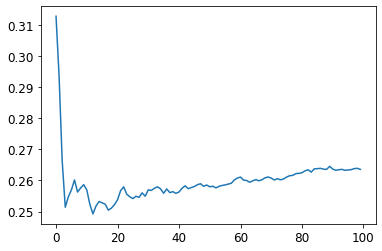

In [366]:
preds = np.stack([t.predict(val_X.values) for t in rf.estimators_])
plt.plot([mean_absolute_error(preds[:i+1].mean(0), val_y) for i in range(100)])

We can see that error decreases sharply as we introduce the first few additional trees, but returns flatten out as we get past 20. We would expect to see a smoother decreasing curve on larger datasets. Given our results I suppose it's worth trying a number of estimators closer to 20.

Another technique we can use when analyzing a random forest is *feature importance*, which measures how vital a given feature is for constructing decision trees. We would expect the features we saw in our original decision tree (Sex & PClass) to all be relatively important:

<AxesSubplot:ylabel='cols'>

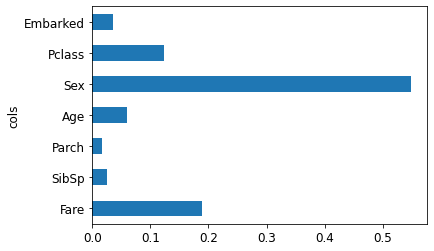

In [367]:
pd.DataFrame(dict(cols=trn_X.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh', legend=False)

It looks like some of the columns (Embarked, Parch, SibSp) are deemed relatively useless compared to other columns like Age, PClass, & Fare. Let's remove those columns from our dataset to see if simplifying can help improve our accuracy.

This technique can also be a powerful feature selection tool, even if you don't intend to use a random forest as your final model. It can help cull a field of many features into only a collection of important, predictive ones.

First, we'll try removing the un-important columns, and then we can try decreasing the number of trees.

In [373]:
df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

def preprocess_df(data, is_test=False):
    modes = data.mode().iloc[0]
    data.fillna(modes, inplace=True)
    data['Sex'] = pd.Categorical(data.Sex).codes
    data['Embarked'] = pd.Categorical(data.Embarked).codes
    inputs = data[['Fare', 'Age', 'Sex', 'Pclass']]
    actuals = None
    if not is_test:
        actuals = df['Survived']
    return inputs, actuals

train_inputs, train_actuals = preprocess_df(df)
test_inputs, _ = preprocess_df(test_df, is_test=True)
train_inputs.head()
trn_X, val_X, trn_y, val_y = train_test_split(train_inputs, train_actuals, test_size=0.2, random_state=99)
rf = RandomForestClassifier(100, min_samples_leaf = 20, oob_score=True)
rf.fit(trn_X.values, trn_y.values)
mean_absolute_error(val_y.values, rf.predict(val_X.values))

0.2681564245810056

Here our accuracy did not fare better. We can make another Kaggle submission and then try decreasing the number of trees.

In [374]:
make_submission(rf.predict(test_inputs.values), test_df, 'rf_2')

For this submission we saw an accuracy of 76.7% which is better than our last but not our best yet! Let's try decreasing the number of estimators from 100 to 20.

In [375]:
rf = RandomForestClassifier(20, min_samples_leaf = 20, oob_score=True)
rf.fit(trn_X.values, trn_y.values)
mean_absolute_error(val_y.values, rf.predict(val_X.values))

0.26256983240223464

In [ ]:
make_submission(rf.predict(test_inputs.values), test_df, 'rf_3')

For this submission we saw 76.5% accuracy, once again not an improvement. One last thing we could try is increasing the number of samples per leaf to a higher number, perhaps something close to 100 given we saw decent performance with a decision tree with leaves of that size. I'll choose min_samples_leaf=90 and give it one more try:

In [376]:
rf = RandomForestClassifier(20, min_samples_leaf = 90, oob_score=True)
rf.fit(trn_X.values, trn_y.values)
mean_absolute_error(val_y.values, rf.predict(val_X.values))

0.2737430167597765

In [ ]:
make_submission(rf.predict(test_inputs.values), test_df, 'rf_4')

We actually achieved the same performance as last time with this new min leaf size (76.5%). I'll iterate again that on this particular dataset tuning techniques are mostly a wash, but given a larger dataset they have proven effectiveness. In the future we can try utilizing these techniques on a larger dataset to see how they positively influence our accuracy.